# Potrebni paketi

In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score as r2, mean_squared_error as mse, mean_absolute_error as mae, roc_auc_score as roc_auc
import math
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter("ignore")
from sklearn.feature_selection import VarianceThreshold
import scikitplot as skplt

# Funkcije

In [2]:
def str_to_date(date):
    return datetime.strptime(date, '%Y-%m-%d').date()

In [3]:
def rmse_score(y_true, y_predict):
    diff = y_true-y_predict
    diff_squared = np.power(diff,2)
    mse = diff_squared.mean()
    rmse = np.sqrt(mse)
    return(rmse)

rmse = make_scorer(rmse_score, greater_is_better=False)

In [4]:
def error_stats(cv_dict):
    stats = {}
    for k,v in cv_dict.items(): 
        stats.update({k:(v.mean(), v.std())})
    return(stats)

In [5]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

# Učitavanje podataka

In [6]:
stores=pd.read_csv('https://raw.githubusercontent.com/DasaMatic/Ozp-ispit/main/store.csv')

In [7]:
stores

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [8]:
train=pd.read_csv('https://raw.githubusercontent.com/DasaMatic/Ozp-ispit/main/train.csv',  sep=',',
                       parse_dates=['Date'],
                       date_parser=str_to_date,
                       low_memory=False)

In [9]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


# Opis i razumevanje problema

###### Rossmann ima preko 3.000 apoteka u 7 evropskih zemalja. Trenutno, menadžeri Rossmann prodavnica imaju zadatak da predvide svoju dnevnu prodaju. Na prodaju u prodavnicama utiču mnogi faktori, uključujući promocije, konkurenciju, školske i državne praznike, sezonski karakter i lokacija. 

# Opis i razumevanje podataka

## Stores

In [10]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


##### Podaci o prodavnicama imaju 10 kolona: 
###### 1. Store - predstavlja tip prodavnice tj. njen id
###### 2. Store type - predstaclja tip prodavnice i može imati vrednosti: a, b, c ili d
###### 3. Assortment - predstavlja tip asortimana koji se prodaje u prodavnici i može imati sedeće vrednosti: a (basic), b (extra), c(extended)
###### 4. CompetitionDistance - predstavlja daljinu u metrima od najbliže konkurentske prodavnice
###### 5. CompetitionOpenSinceMonth - predstavlja mesec kada se najbliža konkurentska prodavnica otvorila
###### 6. CompetitionOpenSinceYear - predstavlja godinu kada se najbliža konkurentska prodavnica otvorila
###### 7. Promo2 - predstavlja kontinuiranu i uzastopna promociju za neke prodavnice: 0 = prodavnica ne učestvuje, 1 = prodavnica učestvuje
###### 8. Promo2SinceWeek - predstavlja kalendarsku nedelju kada je prodavnica počela da učestvuje u Promo2
###### 9. Promo2SinceYear - predstavlja kalendarsku godinu kada je prodavnica počela da učestvuje u Promo2
###### 10. PromoInterval - predstavlja uzastopne intervale u kojima se Promo2 pokreće, imenujući mesece kada promocija počinje iznova. Na primer. „Feb, maj, avgust, novembar“ znači da svaki krug počinje u februaru, maju, avgustu, novembru bilo koje godine za tu prodavnicu

In [11]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


## Nedostajuće vrednosti

In [12]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

###### U skupu podataka za Stores, primećujemo da imamo nedostajuće pdatke za sledeće atribute:
###### 1. CompetitionDistance i to za 3 prodavnice
###### 2. CompetitionOpenSinceMonth i to za 354 prodavnice
###### 3. CompetitionOpenSinceYear i to za 354 prodavnice
###### 4. Promo2SinceWeek i to za 544 prodavnice
###### 5. Promo2SinceYear i to za 544 prodavnice
###### 6. PromoInterval i to za 544 prodavnice
###### Intuitivno je jasno da ukoliko nemamo podatke za Godinu kada je najbliži konkurent otvorio svoju prodavnicu, nećemo imati ni mesec, zbog toga imamo 354 N/A vrednosti za CompetitionOpenSinceMonth i CompetitionOpenSinceYear. 
###### Takođe, ukoliko neka prodavnica ne učestvuje u Promo2, onda nećemo imati podatke ni za atribute Promo2SinceWeek, Promo2SinceYear i PromoInterval. 
###### Proverićemo da li CompetitionDistance N/A podaci odgovaraju N/A vredostima CompetitionOpenSinceMonth i CompetitionOpenSinceYear, jer ukoliko nemamo CompetitionDistance, ne bi trebalo da imamo ova dva atributa. 
###### Takođe, proverićemo da li se poklapaju parovi vrednosti za ostale atribute.

In [13]:
stores.loc[stores['CompetitionDistance'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


###### Primećujemo da prodavnice koje nemaju vrednost za CompetitonDistance nemaju ni vrednosti za CompetitionOpenSinceMonth i CompetitionOpenSinceYear, što je u redu.

In [14]:
na_for_CompetitionOpenSinceMonth=stores['CompetitionOpenSinceMonth'].isna()

In [15]:
na_for_CompetitionOpenSinceYear=stores['CompetitionOpenSinceYear'].isna()

In [16]:
pom=pd.DataFrame(na_for_CompetitionOpenSinceMonth)

In [17]:
pom['CompetitionOpenSinceYear']=na_for_CompetitionOpenSinceYear

In [18]:
pom

,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
1110,False,False
1111,False,False
1112,True,True
1113,True,True


In [19]:
pom['CompetitionOpenSinceMonth'] = pom['CompetitionOpenSinceMonth'].astype(int)

In [20]:
pom['CompetitionOpenSinceYear'] = pom['CompetitionOpenSinceYear'].astype(int)

In [21]:
pom['sum']=pom['CompetitionOpenSinceYear']+pom['CompetitionOpenSinceMonth']

In [22]:
pom

,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,sum
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
1110,0,0,0
1111,0,0,0
1112,1,1,2
1113,1,1,2


In [23]:
pom.loc[pom['sum']==1]

,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,sum


###### Dakle, poklapaju se nedostajuće vrednosti. Ukoliko nemamo podatke za CompetitionOpenSinceYear nemamo ni za CompetitionOpenSinceMonth, tako i treba da bude. 
###### Ostaje nam da proverimo na isti način da li ukoliko nemamo podatke Promo2SinceYear nemamo ni za Promo2SinceWeek i PromoInterval. Takođe, moguće je da za 544 prodavnica nemamo podatke za ove atribute baš zato što te prodavnice ne učestvuju u Promo2, tj. za Promo2 imaju vrednost 0. To je potrebno proveriti.

In [24]:
na_for_Promo2SinceYear=stores['Promo2SinceYear'].isna()

In [25]:
na_for_Promo2SinceWeek=stores['Promo2SinceWeek'].isna()

In [26]:
na_for_PromoInterval=stores['PromoInterval'].isna()

In [27]:
pom=pd.DataFrame(na_for_Promo2SinceYear)

In [28]:
pom['Promo2SinceWeek']=na_for_Promo2SinceWeek

In [29]:
pom['PromoInterval']=na_for_PromoInterval

In [30]:
pom['Promo2SinceYear'] = pom['Promo2SinceYear'].astype(int)

In [31]:
pom['Promo2SinceWeek'] = pom['Promo2SinceWeek'].astype(int)

In [32]:
pom['PromoInterval'] = pom['PromoInterval'].astype(int)

In [33]:
pom['sum']=pom['Promo2SinceYear']+pom['Promo2SinceWeek']+pom['PromoInterval']

In [34]:
pom

,Promo2SinceYear,Promo2SinceWeek,PromoInterval,sum
0,1,1,1,3
1,0,0,0,0
2,0,0,0,0
3,1,1,1,3
4,1,1,1,3
...,...,...,...,...
1110,0,0,0,0
1111,1,1,1,3
1112,1,1,1,3
1113,1,1,1,3


In [35]:
pom.loc[(pom['sum']==1) | (pom['sum']==2)]

,Promo2SinceYear,Promo2SinceWeek,PromoInterval,sum


###### Atributi se poklapaju.

In [36]:
len(stores.loc[stores['Promo2']==0])

544

###### Broj prodavnica koje ne učestvuju u Promo2 je 544 i taj broj se poklapa sa brojem nedostajućih vrednosti za Promo2SinceYear, Promo2SinceWeek i PromoInterval. To nam ukazuje da je velika verovatnoća da su te kolone povezane i da te N/A vrednosti su posledica toga što prodavnica ne učestvuje u promociji. Potrebno je to proveriti.

In [37]:
pom['Promo2']=stores['Promo2']

In [38]:
pom

,Promo2SinceYear,Promo2SinceWeek,PromoInterval,sum,Promo2
0,1,1,1,3,0
1,0,0,0,0,1
2,0,0,0,0,1
3,1,1,1,3,0
4,1,1,1,3,0
...,...,...,...,...,...
1110,0,0,0,0,1
1111,1,1,1,3,0
1112,1,1,1,3,0
1113,1,1,1,3,0


###### Ukoliko je vrednost Promo2 za prodavnicu 0, onda treba biti za Promo2SinceYear, Promo2SinceWeek i PromoInterval biti 1 (True da je N/A vrednost) i za tu prodavnicu sum = 3. Ako je Promo2 = 1, onda sum treba da bude jednako 0.

In [39]:
len(pom.loc[(pom['sum']==0) | (pom['Promo2']==1)])

571

In [40]:
len(pom.loc[(pom['sum']==3) | (pom['Promo2']==0)])

544

###### Dakle, postavili smo dobre pretpostavke, 544 prodavnica od 1115 ne učestvuje u Promo2 i zbog toga ima nedostajuće podatke za Promo2SinceYear, Promo2SinceWeek i PromoInterval. Broj prodavnica koji učestvuje u Promo2 je 571 i ima podatke za ove atribute.

###### Nedostajućim vrednostima za atribut CompetitionDistance dajemo vrednost medijane.

In [41]:
stores['CompetitionDistance'].fillna(stores['CompetitionDistance'].median(), inplace=True)

###### Nedostajućim vrednostima za atribute CompetitionOpenSinceMonth i CompetitionOpenSinceYear dajemo vrednost 0 što će ukazivati da ne znamo kada su se ti konkurenti otvotili.

In [42]:
stores['CompetitionOpenSinceMonth'] = stores['CompetitionOpenSinceMonth'].fillna(0)

In [43]:
stores['CompetitionOpenSinceYear'] = stores['CompetitionOpenSinceYear'].fillna(0)

###### Nedostajućim vrednostima za atribute Promo2SinceYear i Promo2SinceWeek dajemo vrednost 0, a za PromoInterval none. Ove vrednosti ukazuju da ta poravnica ne učestvuje u Promo2.

In [44]:
stores['Promo2SinceWeek'] = stores['Promo2SinceWeek'].fillna(0)

In [45]:
stores['Promo2SinceYear'] = stores['Promo2SinceYear'].fillna(0)

In [46]:
stores['PromoInterval'] = stores['PromoInterval'].fillna('none')

In [47]:
stores.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

###### Ovim je završena analiza nedostajućih podataka za skup podataka Stores.

# Train

In [48]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


##### Podaci o prodavnicama imaju 10 kolona: 
###### 1. Store - predstavlja tip prodavnice tj. njen id
###### 2. DayOfWeek - redni broj data u nedelji datuma (Date)
###### 3. Date - kalendarski datum
###### 4. Sales - prodaja za određeni datum
###### 5. Customers - broj kupaca koji je obavio kupovinu na određeni datum
###### 6. Open - da li je prodavnica bila otvorena na određeni datum (0 = prodavnica zatvorena, 1 = prodavnica otvorena)
###### 7. Promo - da li prodavnica ima neku promociju taj dan (0 = nema , 1 = ima)
###### 8. SateHoliday - označava državni praznik. Obično su sve prodavnice, osim nekoliko izuzetaka, zatvorene na državne praznike.  a = državni praznik, b = praznik Uskrsa, c = Božić, 0 = nema *
###### 9. SchoolHoliday - označava da li je zatvaranje javnih škola tj. da li je školski praznik *
###### * Sve škole su zatvorene državnim praznicima i vikendom.

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [50]:
train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

###### Kolonu Date ćemo razdvojiti u Day, Month i Year.

In [51]:
train['Day'] = train['Date'].dt.day
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year

In [52]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,31,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1,1,2013
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1,1,2013
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1,1,2013
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1,1,2013


###### Nemamo nedostajućih vrednosti u skupu podataka train.

## Spajanje podataka u jedan skup podataka

In [53]:
df=pd.merge(stores, train, on='Store',how='inner')

In [54]:
len(df)

1017209

In [55]:
len(train)

1017209

In [56]:
df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,2015-07-31,5263,555,1,1,0,1,31,7,2015
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,2015-07-30,5020,546,1,1,0,1,30,7,2015
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,2015-07-29,4782,523,1,1,0,1,29,7,2015
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,2015-07-28,5011,560,1,1,0,1,28,7,2015
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,2015-07-27,6102,612,1,1,0,1,27,7,2015


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   StoreType                  1017209 non-null  object        
 2   Assortment                 1017209 non-null  object        
 3   CompetitionDistance        1017209 non-null  float64       
 4   CompetitionOpenSinceMonth  1017209 non-null  float64       
 5   CompetitionOpenSinceYear   1017209 non-null  float64       
 6   Promo2                     1017209 non-null  int64         
 7   Promo2SinceWeek            1017209 non-null  float64       
 8   Promo2SinceYear            1017209 non-null  float64       
 9   PromoInterval              1017209 non-null  object        
 10  DayOfWeek                  1017209 non-null  int64         
 11  Date                       1017209 no

In [58]:
df.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
Day                          0
Month                        0
Year                         0
dtype: int64

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   StoreType                  1017209 non-null  object        
 2   Assortment                 1017209 non-null  object        
 3   CompetitionDistance        1017209 non-null  float64       
 4   CompetitionOpenSinceMonth  1017209 non-null  float64       
 5   CompetitionOpenSinceYear   1017209 non-null  float64       
 6   Promo2                     1017209 non-null  int64         
 7   Promo2SinceWeek            1017209 non-null  float64       
 8   Promo2SinceYear            1017209 non-null  float64       
 9   PromoInterval              1017209 non-null  object        
 10  DayOfWeek                  1017209 non-null  int64         
 11  Date                       1017209 no

In [60]:
df['StateHoliday'] = df['StateHoliday'].astype('category')
df['Assortment'] = df['Assortment'].astype('category')
df['StoreType'] = df['StoreType'].astype('category')
df['PromoInterval'] = df['PromoInterval'].astype('category')

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   StoreType                  1017209 non-null  category      
 2   Assortment                 1017209 non-null  category      
 3   CompetitionDistance        1017209 non-null  float64       
 4   CompetitionOpenSinceMonth  1017209 non-null  float64       
 5   CompetitionOpenSinceYear   1017209 non-null  float64       
 6   Promo2                     1017209 non-null  int64         
 7   Promo2SinceWeek            1017209 non-null  float64       
 8   Promo2SinceYear            1017209 non-null  float64       
 9   PromoInterval              1017209 non-null  category      
 10  DayOfWeek                  1017209 non-null  int64         
 11  Date                       1017209 no

In [62]:
df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Day,Month,Year
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,5.422021e+03,4.926878e+00,1.370173e+03,5.005638e-01,1.164767e+01,1.007011e+03,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,1.570279e+01,5.846762e+00,2.013832e+03
std,3.219087e+02,7.706918e+03,4.283543e+00,9.353634e+02,4.999999e-01,1.532393e+01,1.005877e+03,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,8.787638e+00,3.326097e+00,7.773960e-01
min,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.013000e+03
25%,2.800000e+02,7.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,3.000000e+00,2.013000e+03
50%,5.580000e+02,2.325000e+03,4.000000e+00,2.006000e+03,1.000000e+00,1.000000e+00,2.009000e+03,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,6.000000e+00,2.014000e+03
75%,8.380000e+02,6.880000e+03,9.000000e+00,2.011000e+03,1.000000e+00,2.200000e+01,2.012000e+03,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.300000e+01,8.000000e+00,2.014000e+03
max,1.115000e+03,7.586000e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,3.100000e+01,1.200000e+01,2.015000e+03


## Dodatni opis i razumevanje podataka

### Store Types

Text(0.5, 1.0, 'StoreType pie chart')

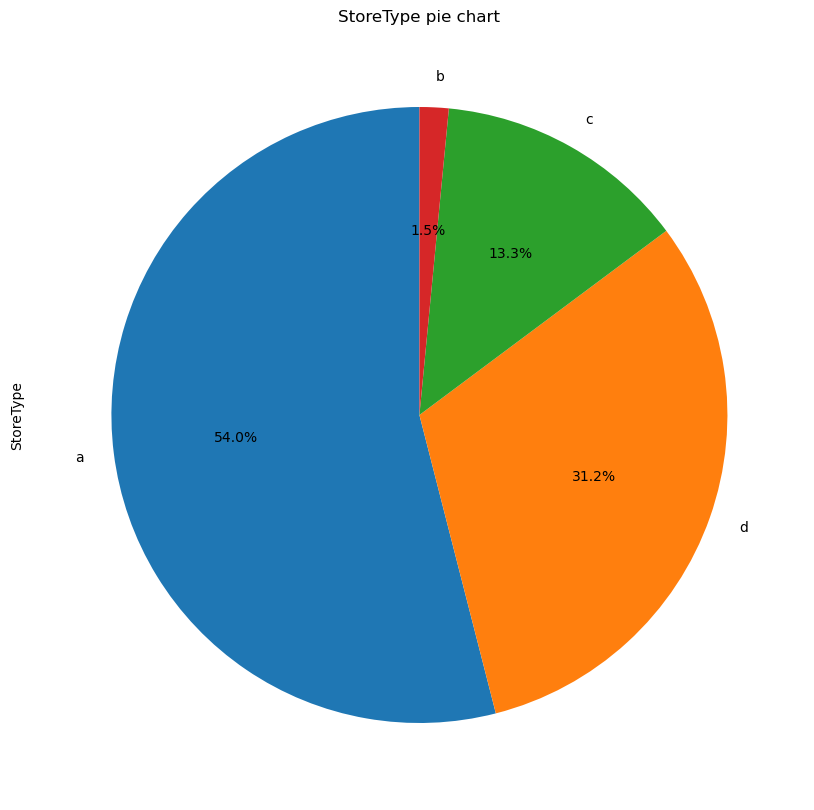

In [63]:
store_types = stores['StoreType'].value_counts().sort_values(ascending=False)
ax= store_types.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
ax.set_title('StoreType pie chart')

### Assortment

Text(0.5, 1.0, 'Assortment pie chart')

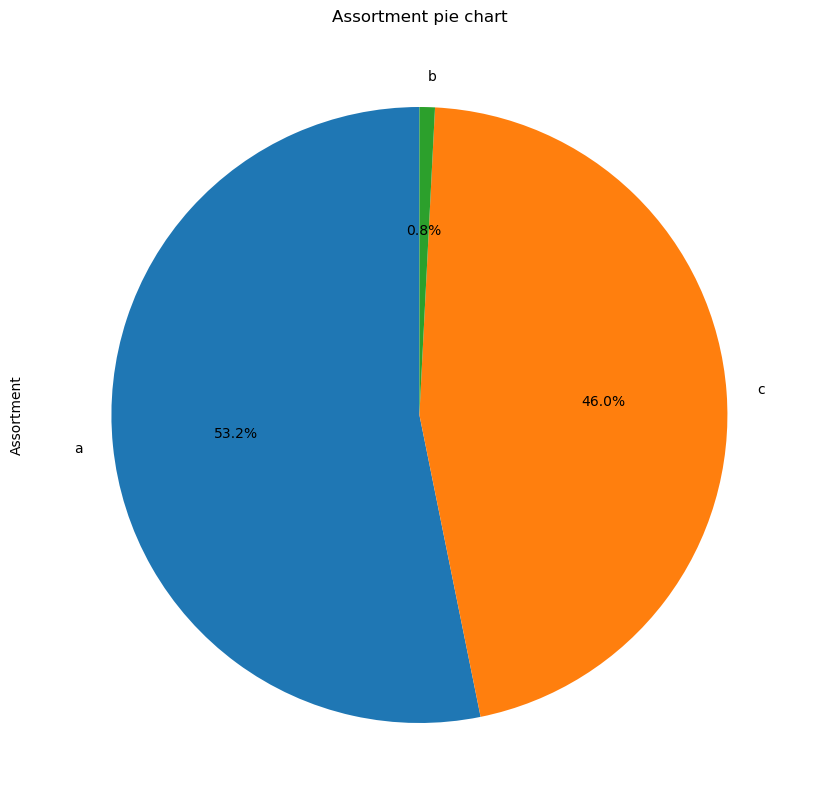

In [64]:
assortments = stores['Assortment'].value_counts().sort_values(ascending=False)
ax=assortments.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
ax.set_title('Assortment pie chart')

### Competition distance

Text(0.5, 1.0, 'CompetitionDistance Histogram')

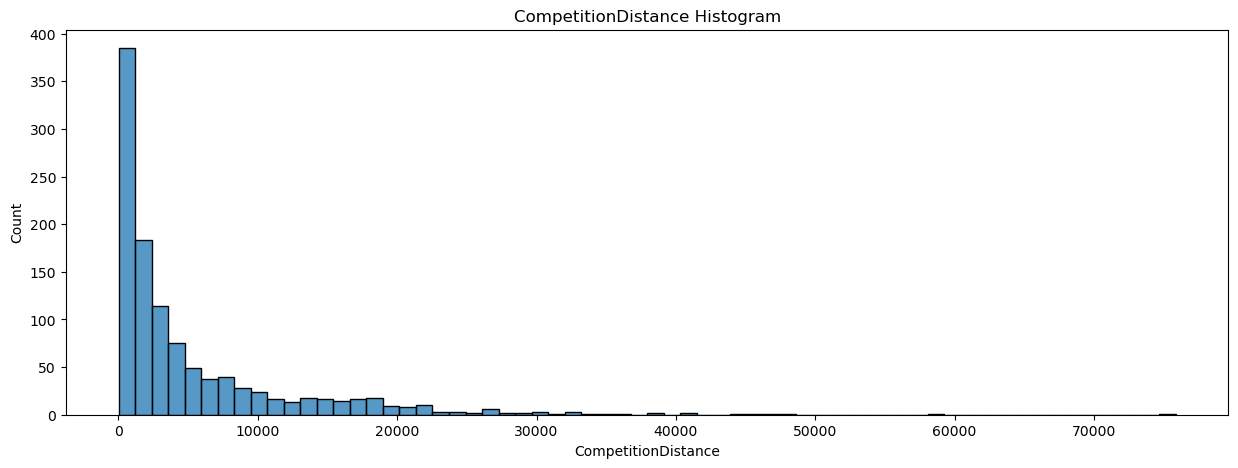

In [65]:
fig, ax = plt.subplots(figsize=(15,5))
g = sns.histplot(data=stores, x='CompetitionDistance',ax=ax)
g.set_title('CompetitionDistance Histogram')

### CompetitionOpenSinceYear

Text(0.5, 1.0, 'CompetitionOpenSinceYear Histogram')

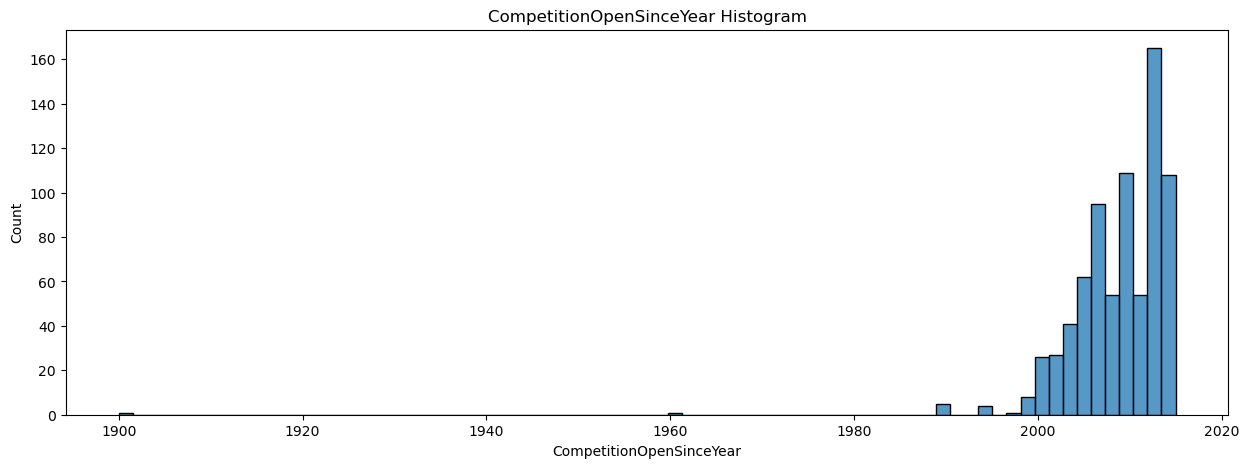

In [66]:
fig, ax = plt.subplots(figsize=(15,5))
g = sns.histplot(data=stores[stores['CompetitionOpenSinceYear']>0], x='CompetitionOpenSinceYear',ax=ax)
g.set_title('CompetitionOpenSinceYear Histogram')

### Promo2

Text(0.5, 1.0, 'Promo2 Pie chart')

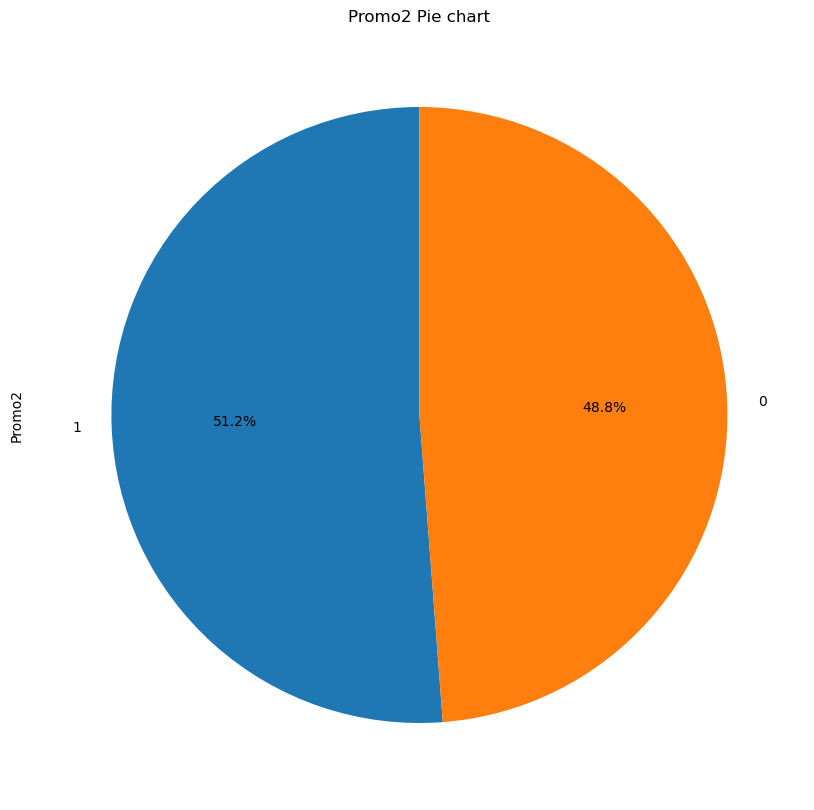

In [67]:
promo2s = stores['Promo2'].value_counts().sort_values(ascending=False)
ax = promo2s.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
ax.set_title('Promo2 Pie chart')

### Promo2SinceYear

Text(0.5, 1.0, 'Promo2SinceYear Histogram')

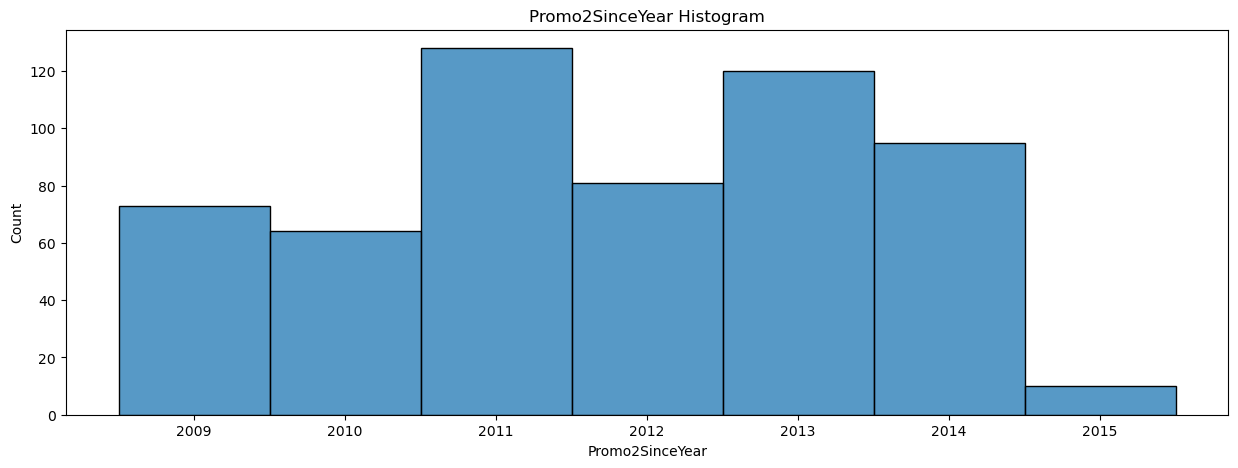

In [68]:
fig, ax = plt.subplots(figsize=(15,5))
g = sns.histplot(data=stores[stores['Promo2SinceYear']>0], x='Promo2SinceYear',ax=ax,discrete=True)
g.set_title('Promo2SinceYear Histogram')

### PromoInterval

Text(0.5, 1.0, 'PromoInterval pie chart')

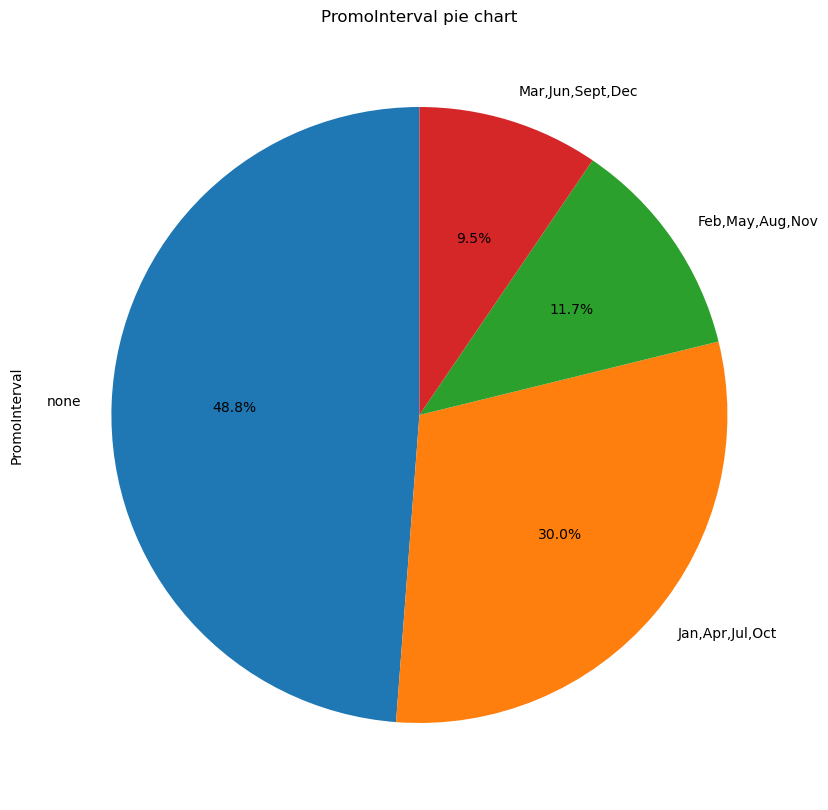

In [69]:
promo_intervals = stores['PromoInterval'].value_counts().sort_values(ascending=False)
ax = promo_intervals.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
ax.set_title('PromoInterval pie chart')

###### Od onih koji učestvuju u Promo2

Text(0.5, 1.0, 'PromoInterval pie chart')

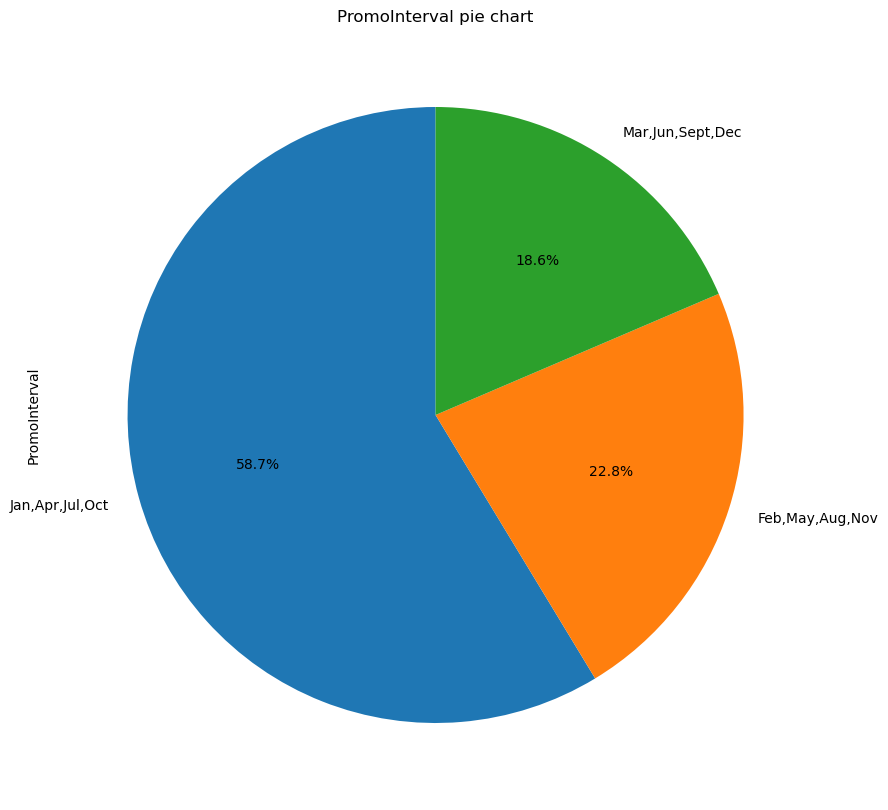

In [70]:
promo_intervals = stores[stores['PromoInterval']!='none']['PromoInterval'].value_counts().sort_values(ascending=False)
ax = promo_intervals.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
ax.set_title('PromoInterval pie chart')

### Date

Text(0, 0.5, 'Date')

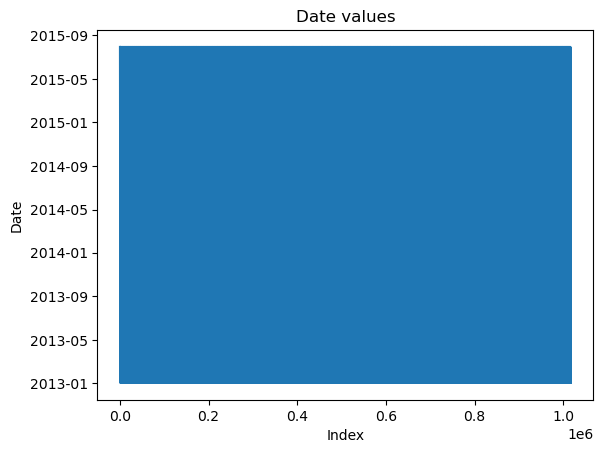

In [71]:
ax =df['Date'].plot.line(title='Date values')
ax.set_xlabel('Index')
ax.set_ylabel('Date')

### DayOfWeek

Text(0.5, 1.0, 'DayOfWeek pie chart')

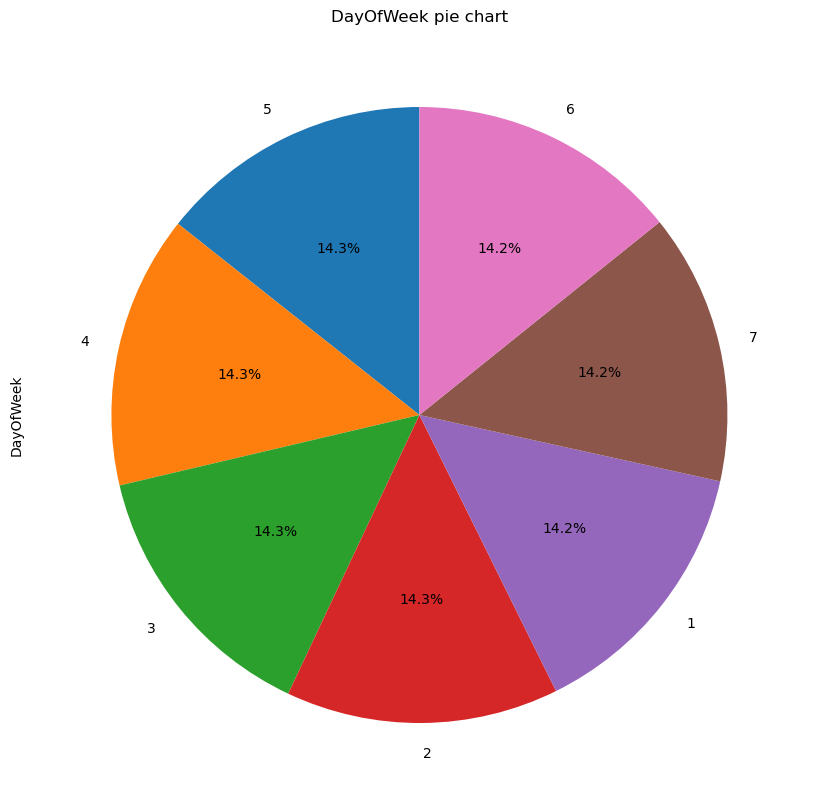

In [72]:
day_of_weeks = train['DayOfWeek'].value_counts().sort_values(ascending=False)
ax = day_of_weeks.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
ax.set_title('DayOfWeek pie chart')

### Sales

Text(0.5, 1.0, 'Sales Histogram')

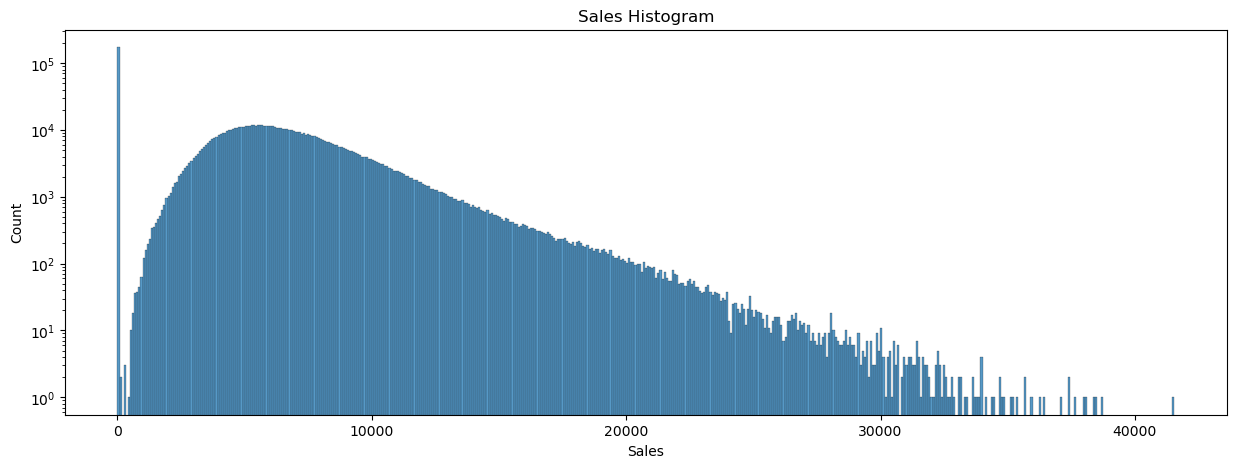

In [73]:
fig, ax = plt.subplots(figsize=(15,5))
g = sns.histplot(data=df, x='Sales',ax=ax)
ax.set_yscale('log')
ax.set_title('Sales Histogram')

### Customers

Text(0.5, 1.0, 'Customers Histogram')

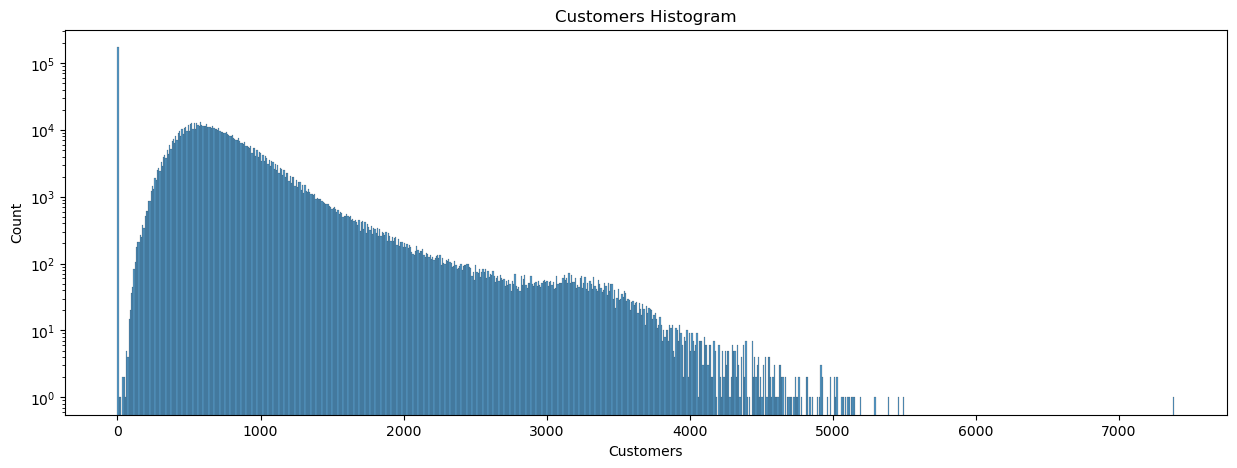

In [74]:
fig, ax = plt.subplots(figsize=(15,5))
g = sns.histplot(data=df, x='Customers',ax=ax)
ax.set_yscale('log')
ax.set_title('Customers Histogram')

### Open

Text(0.5, 1.0, 'Open pie chart')

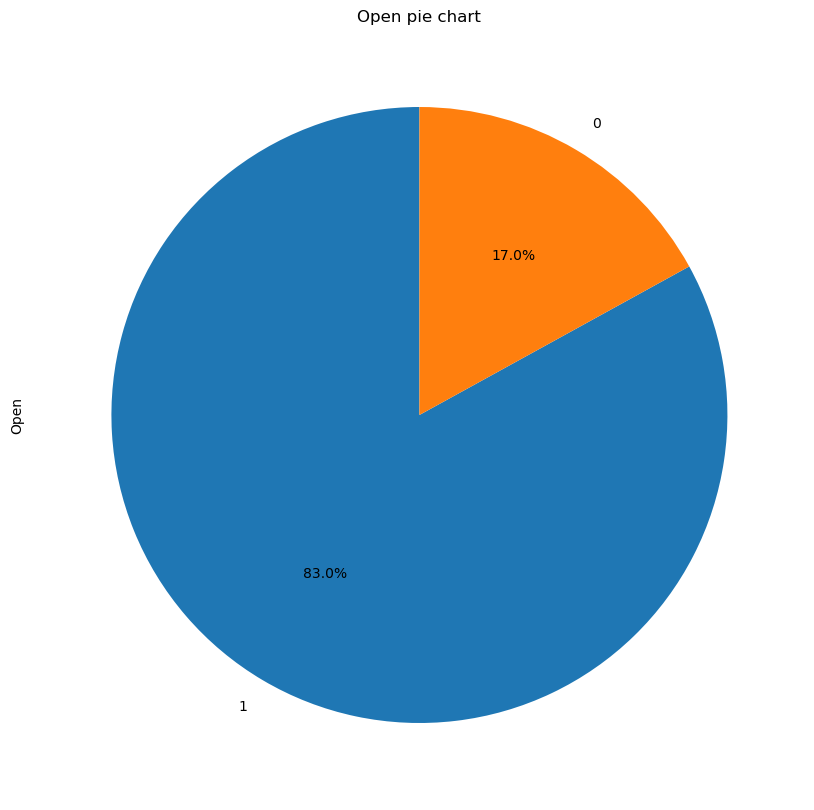

In [75]:
opens = train['Open'].value_counts().sort_values(ascending=False)
ax = opens.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
ax.set_title('Open pie chart')

### Promo

Text(0.5, 1.0, 'Promo pie chart')

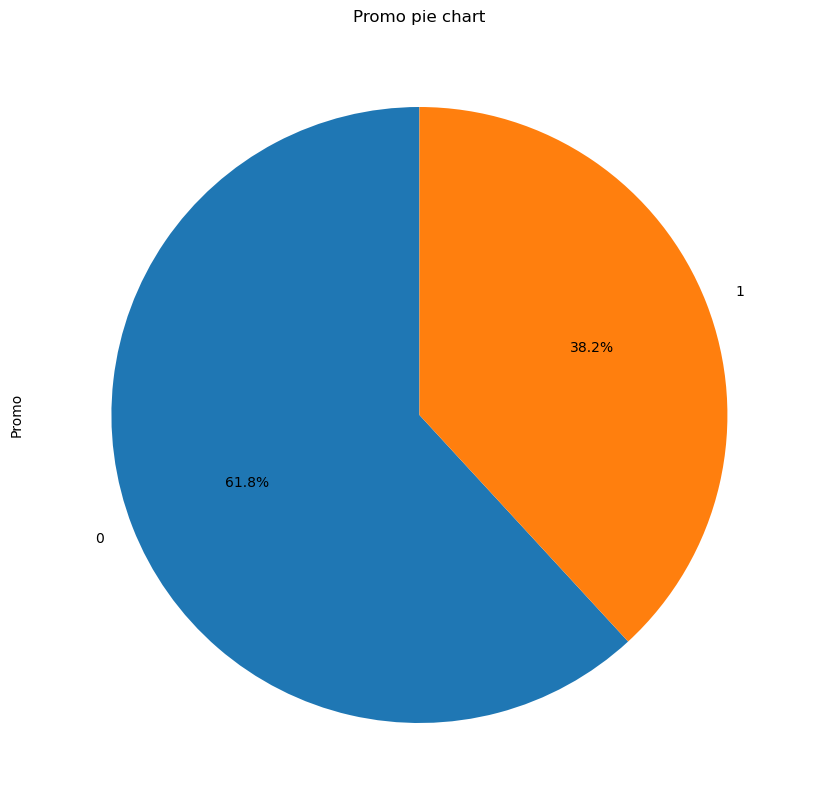

In [76]:
promos = train['Promo'].value_counts().sort_values(ascending=False)
ax = promos.plot.pie(autopct="%.1f%%",startangle=90, figsize=(10,10))
ax.set_title('Promo pie chart')

### SateHoliday

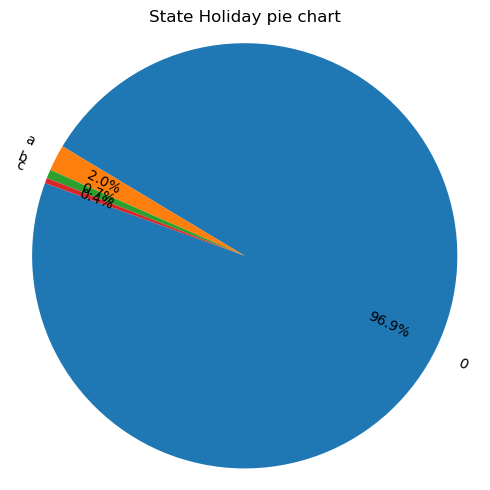

In [77]:
fig, ax = plt.subplots(figsize=(5,5))
state_holidays = train['StateHoliday'].value_counts().sort_values(ascending=False)
_, labels, pct_texts = plt.pie(state_holidays, labels=state_holidays.keys(), autopct="%.1f%%", 
                          startangle=160, rotatelabels=True, pctdistance=0.75)
for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())
plt.title('State Holiday pie chart')
plt.axis('equal')
plt.tight_layout()
plt.show()

### SchoolHoliday

Text(0.5, 1.0, 'SchoolHoliday pie chart')

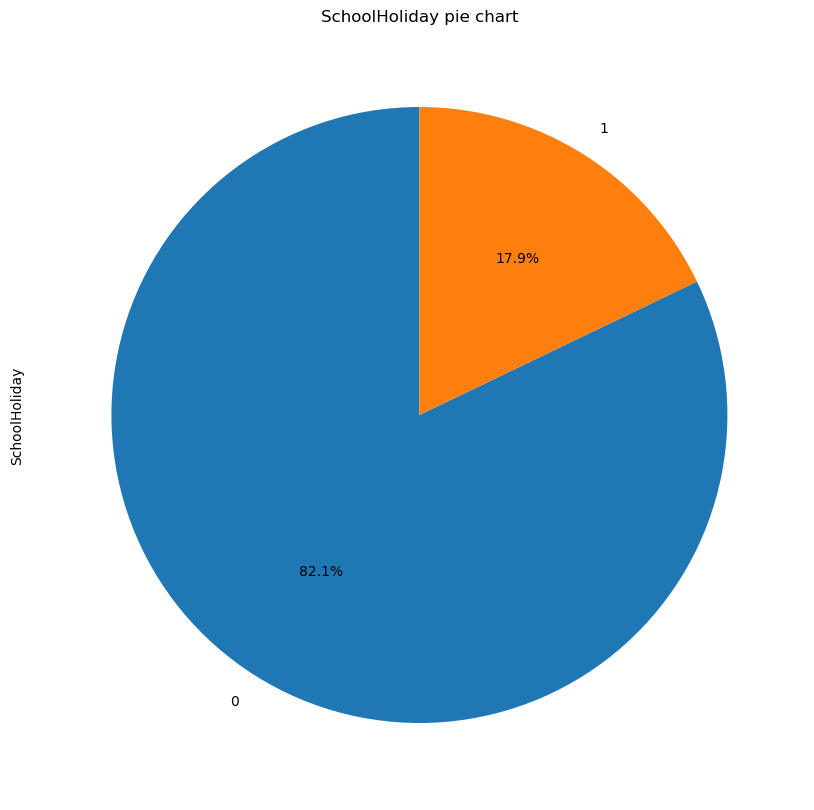

In [78]:
school_holidays=train['SchoolHoliday'].value_counts().sort_values(ascending=False)
ax = school_holidays.plot.pie(autopct="%.1f%%", figsize=(10,10), startangle=90)
ax.set_title('SchoolHoliday pie chart')

### Correlation

<AxesSubplot:>

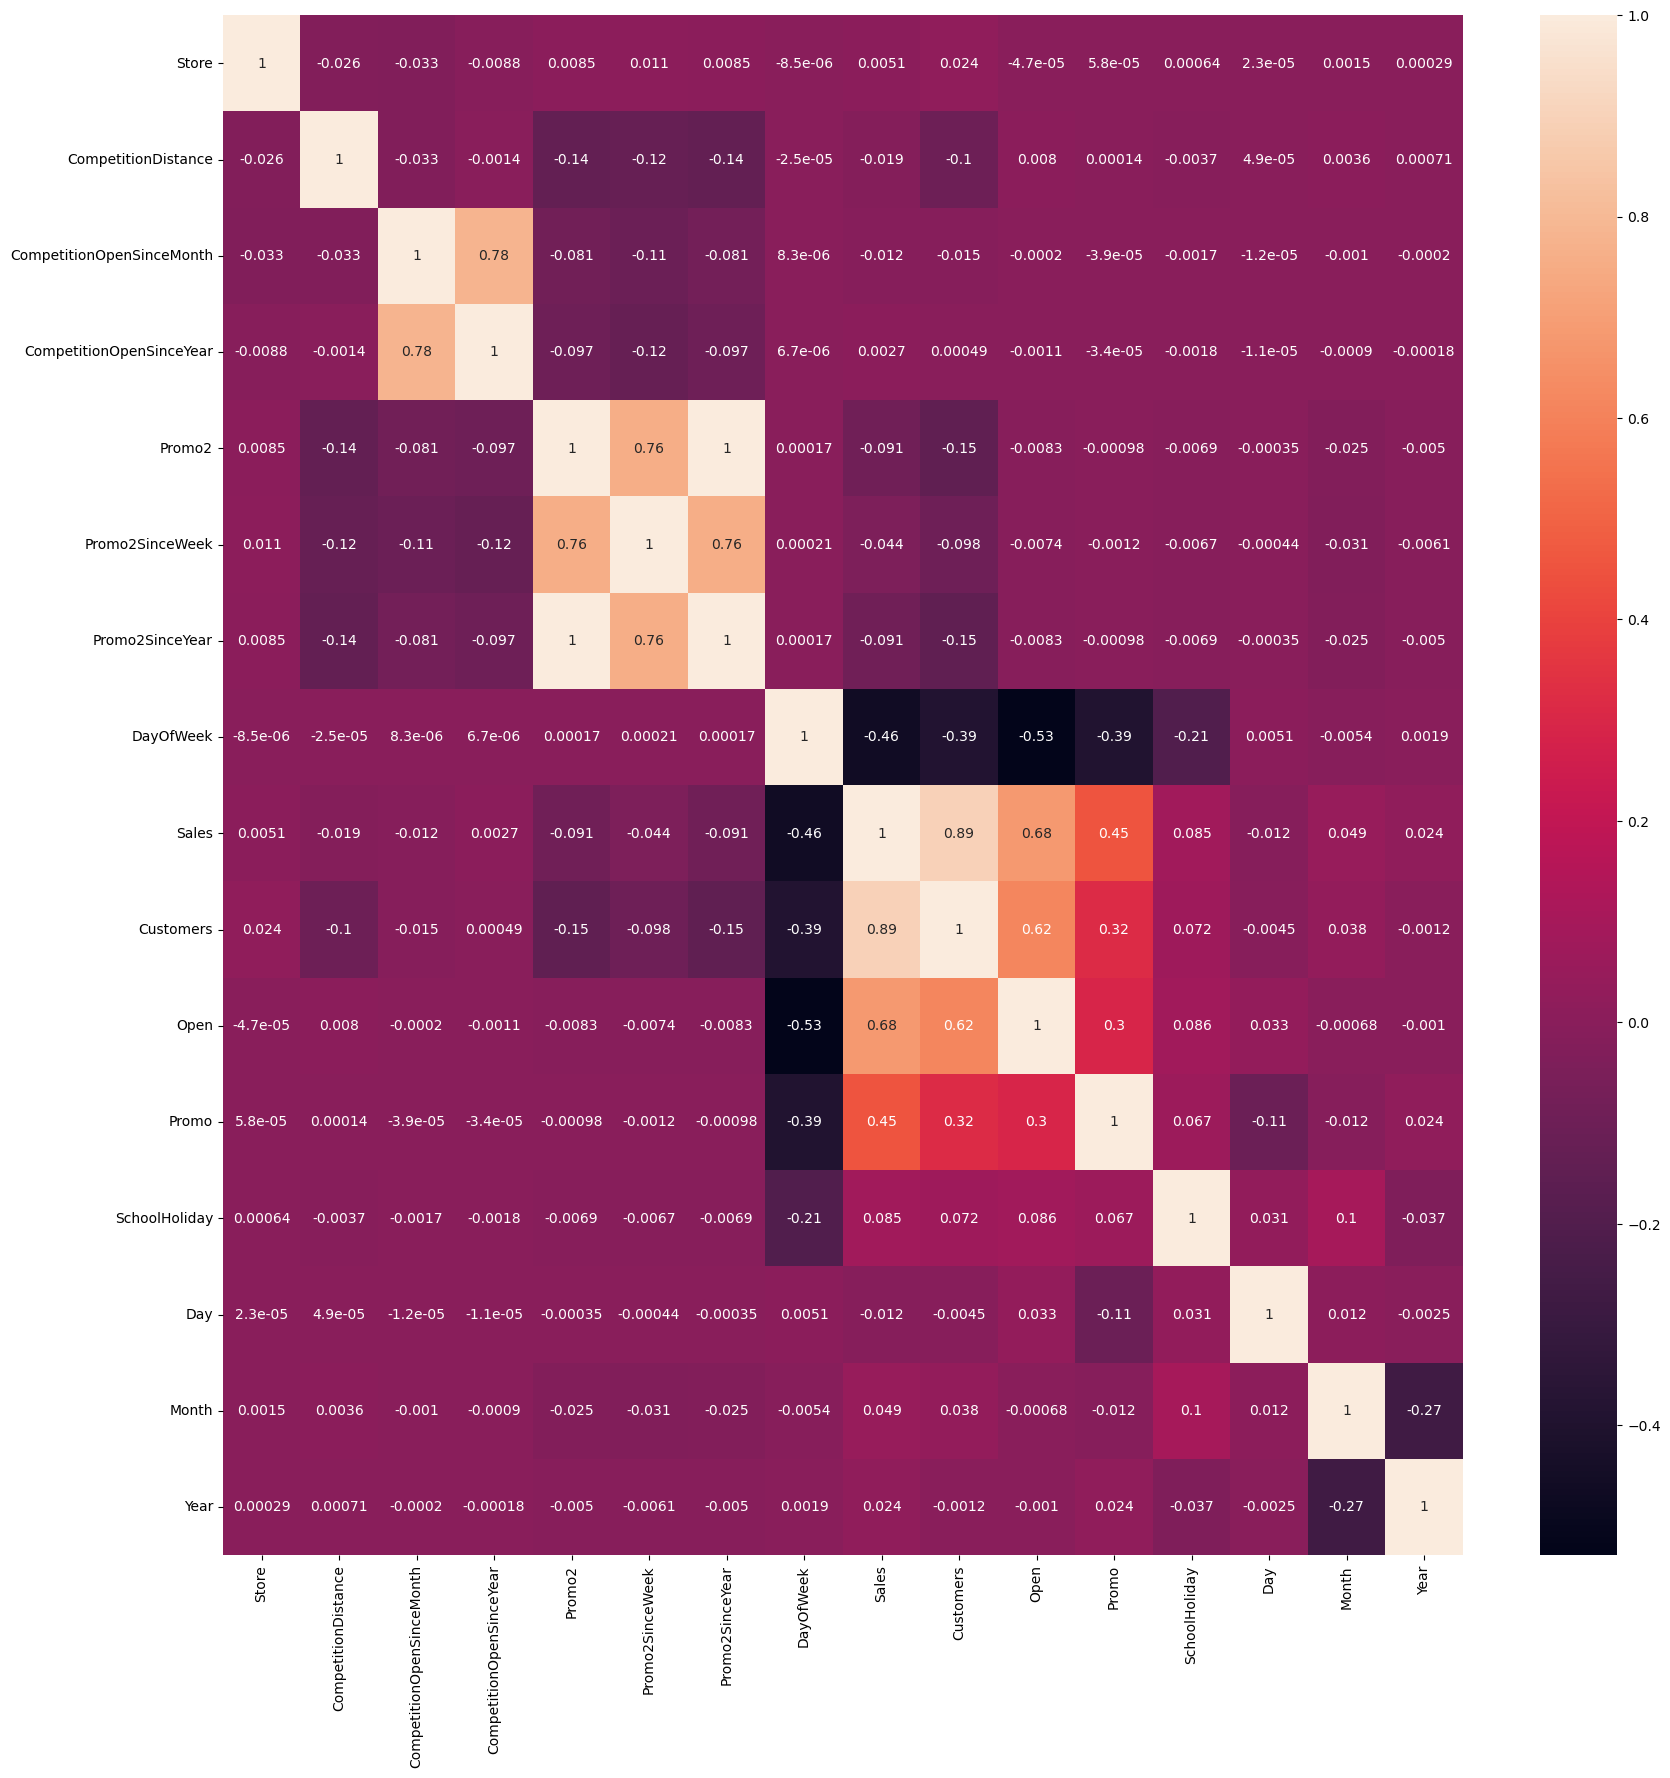

In [79]:
correlations = df.corr()
f,ax =plt.subplots(figsize = (20,20))
sns.heatmap(correlations,annot=True)

### Prosek Customera u odnosu na najbližeg konkurenta

In [80]:
med_distance = df['CompetitionDistance'].median()
med_distance

2325.0

In [81]:
competition_distance_df = df.groupby([df['CompetitionDistance']>med_distance]).groups
competition_distance_df

{False: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], True: [1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 

In [82]:
lower_med, higher_med = competition_distance_df[False], competition_distance_df[True]

In [83]:
lower_med

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1016257, 1016258, 1016259, 1016260, 1016261, 1016262, 1016263,
            1016264, 1016265, 1016266],
           dtype='int64', length=509281)

In [84]:
higher_med

Int64Index([   1884,    1885,    1886,    1887,    1888,    1889,    1890,
               1891,    1892,    1893,
            ...
            1017199, 1017200, 1017201, 1017202, 1017203, 1017204, 1017205,
            1017206, 1017207, 1017208],
           dtype='int64', length=507928)

In [85]:
print(f"lower distance = {df.loc[lower_med]['Customers'].mean()}\nhigher distance = {df.loc[higher_med]['Customers'].mean()}")

lower distance = 713.8031106599303
higher distance = 552.2739305570868


### StateHoliday vs Open

<AxesSubplot:xlabel='StateHoliday'>

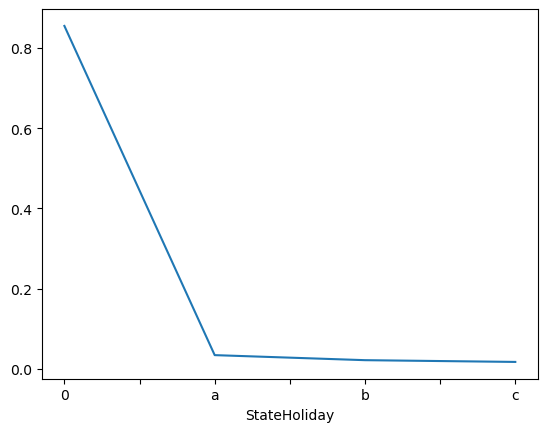

In [86]:
state_holidays = df.groupby('StateHoliday')['Open']
state_holiday_open_rates = state_holidays.sum()/state_holidays.count()
state_holiday_open_rates.plot.line()

### Promo2 vs Sales

<AxesSubplot:xlabel='Promo2', ylabel='Sales'>

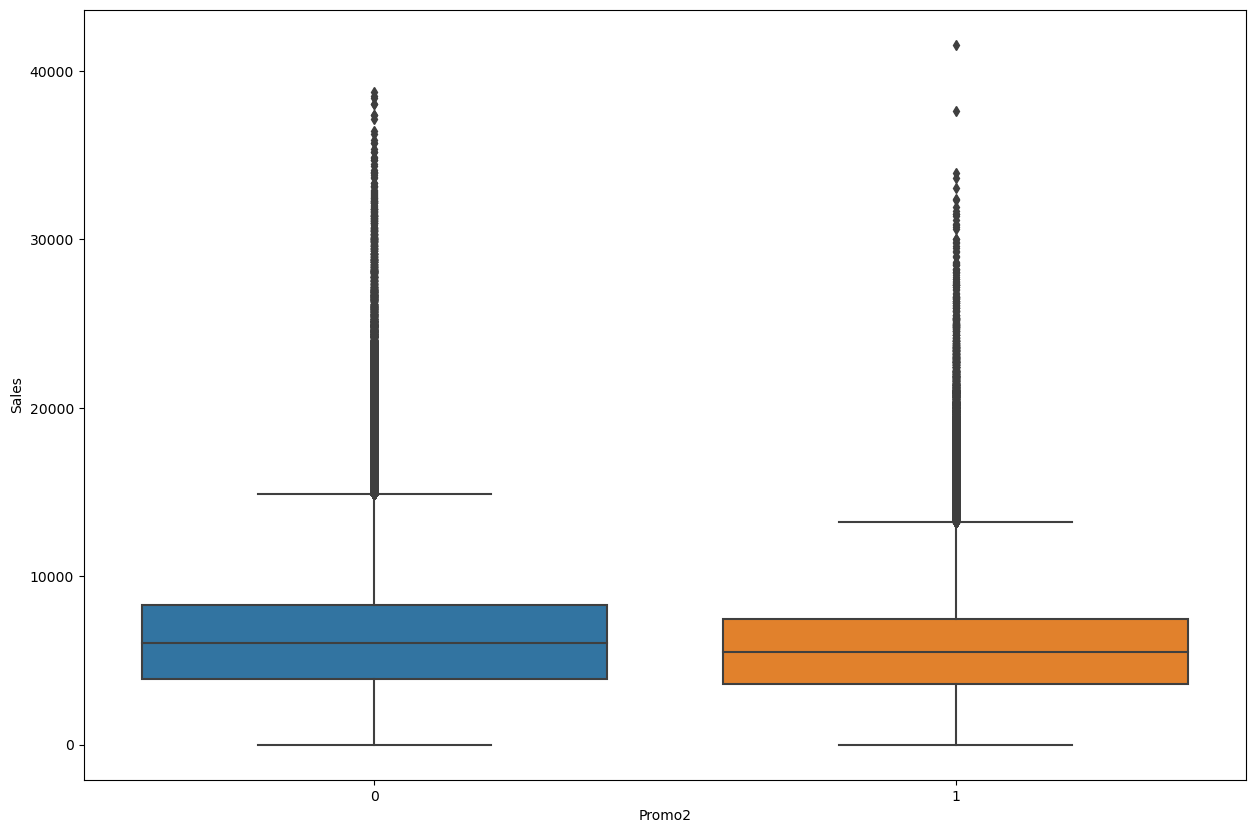

In [87]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x="Promo2", y="Sales", data=df, ax=ax)

### DayOfWeek vs Sales

<AxesSubplot:xlabel='DayOfWeek', ylabel='Sales'>

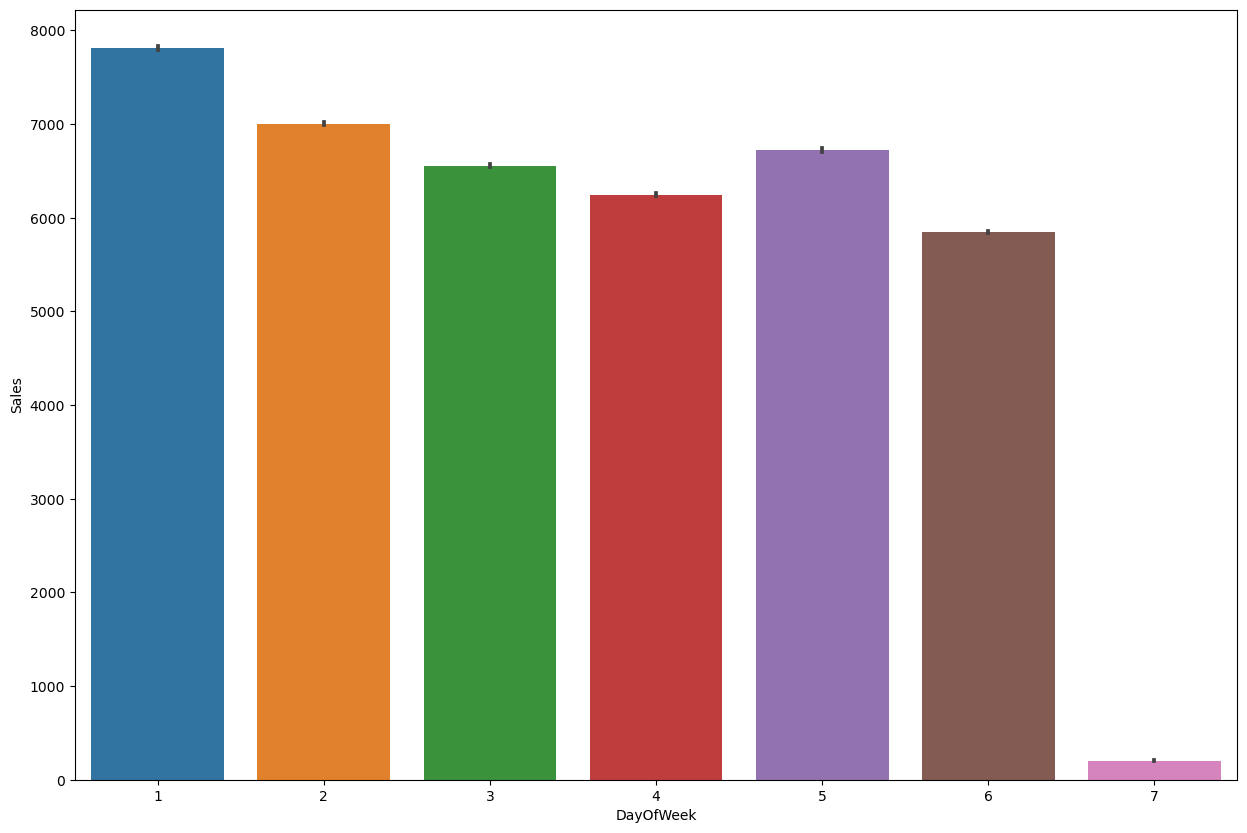

In [88]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="DayOfWeek", y="Sales", data=df)

### Promo vs Sales

<AxesSubplot:xlabel='Promo', ylabel='Sales'>

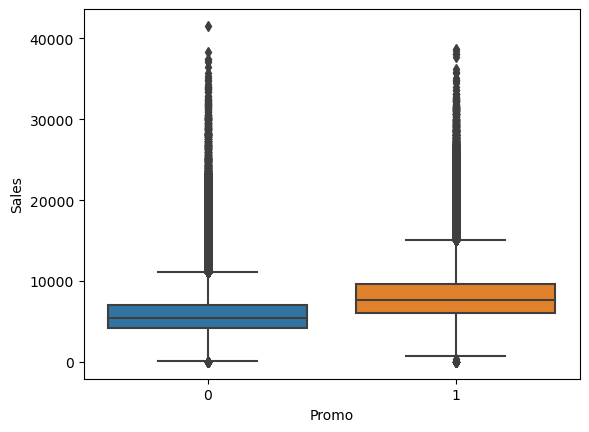

In [89]:
sns.boxplot(data=df[df['Open']==1],x='Promo',y='Sales')

### Customers vs Sales

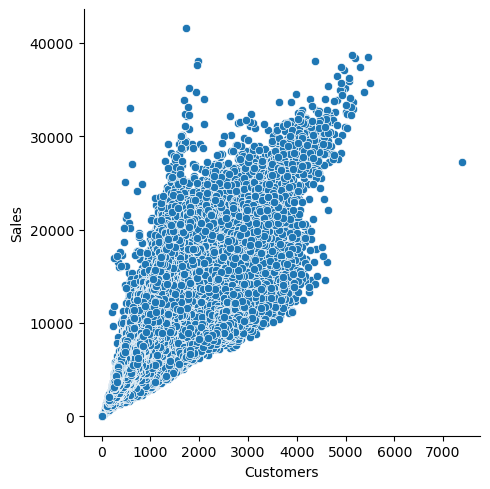

In [90]:
sns.relplot(data=df, x='Customers',y='Sales')

### Priprema podataka

In [91]:
df['CompetitionOpenSince'] = np.where((df['CompetitionOpenSinceMonth'] == 0) & (df['CompetitionOpenSinceYear'] == 0),
                                      0,
                                      (df['Month'] - df['CompetitionOpenSinceMonth']) + 12 * (df['Year'] - df['CompetitionOpenSinceYear']))



In [92]:
df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,CompetitionOpenSince
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,5263,555,1,1,0,1,31,7,2015,82.0
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,5020,546,1,1,0,1,30,7,2015,82.0
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,4782,523,1,1,0,1,29,7,2015,82.0
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,5011,560,1,1,0,1,28,7,2015,82.0
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,6102,612,1,1,0,1,27,7,2015,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,4771,339,1,0,0,1,5,1,2013,0.0
1017205,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,4540,326,1,0,0,1,4,1,2013,0.0
1017206,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,4297,300,1,0,0,1,3,1,2013,0.0
1017207,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,3697,305,1,0,0,1,2,1,2013,0.0


In [93]:
df['is_holiday_state'] = df['StateHoliday'].map({'0': 0,
                                                 'a': 1,
                                                 'b': 1,
                                                 'c': 1
                                                })


In [94]:
df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,...,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,CompetitionOpenSince,is_holiday_state
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,555,1,1,0,1,31,7,2015,82.0,0
1,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,546,1,1,0,1,30,7,2015,82.0,0
2,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,523,1,1,0,1,29,7,2015,82.0,0
3,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,560,1,1,0,1,28,7,2015,82.0,0
4,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none,...,612,1,1,0,1,27,7,2015,82.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,339,1,0,0,1,5,1,2013,0.0,0
1017205,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,326,1,0,0,1,4,1,2013,0.0,0
1017206,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,300,1,0,0,1,3,1,2013,0.0,0
1017207,1115,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",...,305,1,0,0,1,2,1,2013,0.0,0


In [95]:
df = pd.get_dummies(df, columns=['Assortment', 'StoreType', 'PromoInterval'],
                    prefix=['is_Assortment', 'is_StoreType', 'is_PromoInterval']
)

In [96]:
df

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Date,Sales,...,is_Assortment_b,is_Assortment_c,is_StoreType_a,is_StoreType_b,is_StoreType_c,is_StoreType_d,"is_PromoInterval_Feb,May,Aug,Nov","is_PromoInterval_Jan,Apr,Jul,Oct","is_PromoInterval_Mar,Jun,Sept,Dec",is_PromoInterval_none
0,1,1270.0,9.0,2008.0,0,0.0,0.0,5,2015-07-31,5263,...,0,0,0,0,1,0,0,0,0,1
1,1,1270.0,9.0,2008.0,0,0.0,0.0,4,2015-07-30,5020,...,0,0,0,0,1,0,0,0,0,1
2,1,1270.0,9.0,2008.0,0,0.0,0.0,3,2015-07-29,4782,...,0,0,0,0,1,0,0,0,0,1
3,1,1270.0,9.0,2008.0,0,0.0,0.0,2,2015-07-28,5011,...,0,0,0,0,1,0,0,0,0,1
4,1,1270.0,9.0,2008.0,0,0.0,0.0,1,2015-07-27,6102,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5350.0,0.0,0.0,1,22.0,2012.0,6,2013-01-05,4771,...,0,1,0,0,0,1,0,0,1,0
1017205,1115,5350.0,0.0,0.0,1,22.0,2012.0,5,2013-01-04,4540,...,0,1,0,0,0,1,0,0,1,0
1017206,1115,5350.0,0.0,0.0,1,22.0,2012.0,4,2013-01-03,4297,...,0,1,0,0,0,1,0,0,1,0
1017207,1115,5350.0,0.0,0.0,1,22.0,2012.0,3,2013-01-02,3697,...,0,1,0,0,0,1,0,0,1,0


In [97]:
del df['CompetitionOpenSinceYear']
del df['CompetitionOpenSinceMonth']
del df['StateHoliday']
del df['Date']

In [98]:
df.columns

Index(['Store', 'CompetitionDistance', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Day', 'Month', 'Year', 'CompetitionOpenSince',
       'is_holiday_state', 'is_Assortment_a', 'is_Assortment_b',
       'is_Assortment_c', 'is_StoreType_a', 'is_StoreType_b', 'is_StoreType_c',
       'is_StoreType_d', 'is_PromoInterval_Feb,May,Aug,Nov',
       'is_PromoInterval_Jan,Apr,Jul,Oct', 'is_PromoInterval_Mar,Jun,Sept,Dec',
       'is_PromoInterval_none'],
      dtype='object')

In [99]:
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]

In [100]:
df.columns

Index(['Store', 'CompetitionDistance', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Day', 'Month', 'Year', 'CompetitionOpenSince',
       'is_holiday_state', 'is_Assortment_a', 'is_Assortment_b',
       'is_Assortment_c', 'is_StoreType_a', 'is_StoreType_b', 'is_StoreType_c',
       'is_StoreType_d', 'is_PromoInterval_Feb_May_Aug_Nov',
       'is_PromoInterval_Jan_Apr_Jul_Oct', 'is_PromoInterval_Mar_Jun_Sept_Dec',
       'is_PromoInterval_none'],
      dtype='object')

In [101]:
X = df.drop(['Sales'], axis=1)
y = df.Sales

In [102]:
X

,Store,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Customers,Open,Promo,SchoolHoliday,...,is_Assortment_b,is_Assortment_c,is_StoreType_a,is_StoreType_b,is_StoreType_c,is_StoreType_d,is_PromoInterval_Feb_May_Aug_Nov,is_PromoInterval_Jan_Apr_Jul_Oct,is_PromoInterval_Mar_Jun_Sept_Dec,is_PromoInterval_none
0,1,1270.0,0,0.0,0.0,5,555,1,1,1,...,0,0,0,0,1,0,0,0,0,1
1,1,1270.0,0,0.0,0.0,4,546,1,1,1,...,0,0,0,0,1,0,0,0,0,1
2,1,1270.0,0,0.0,0.0,3,523,1,1,1,...,0,0,0,0,1,0,0,0,0,1
3,1,1270.0,0,0.0,0.0,2,560,1,1,1,...,0,0,0,0,1,0,0,0,0,1
4,1,1270.0,0,0.0,0.0,1,612,1,1,1,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5350.0,1,22.0,2012.0,6,339,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1017205,1115,5350.0,1,22.0,2012.0,5,326,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1017206,1115,5350.0,1,22.0,2012.0,4,300,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1017207,1115,5350.0,1,22.0,2012.0,3,305,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [103]:
y

0          5263
1          5020
2          4782
3          5011
4          6102
           ... 
1017204    4771
1017205    4540
1017206    4297
1017207    3697
1017208       0
Name: Sales, Length: 1017209, dtype: int64

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1518)

# Selekcija atributa

In [105]:
selection = VarianceThreshold(0.05)
selection.fit(X_train)

print(selection.get_support())
print('--------------------')
print(selection.get_support().sum())

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True False  True  True False  True  True  True  True
  True  True]
--------------------
23


In [106]:
X_reduced = X_train.loc[:, selection.get_support()]

model = LinearRegression()

scores = cross_validate(model, X_reduced, y_train, cv=10, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'})
print(f'Selektovani atributi: \n')
error_stats(scores)

Selektovani atributi: 



{'fit_time': (0.439790153503418, 0.02586634743749391),
 'score_time': (0.01186819076538086, 0.0031323928098848444),
 'test_MAE': (-874.4504023447655, 2.3842793106666313),
 'test_RMSE': (-1215.0000202562421, 7.2565757425231325),
 'test_R2': (0.9003947174537489, 0.001123837768918691)}

In [107]:
model = Ridge(alpha=1)

scores = cross_validate(model, X_reduced, y_train, cv=10, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'})
print(f'Selektovani atributi: \n')
error_stats(scores)

Selektovani atributi: 



{'fit_time': (0.3047366142272949, 0.01879224535573773),
 'score_time': (0.010122156143188477, 0.0012964217061552468),
 'test_MAE': (-875.0231006635573, 2.331436447853415),
 'test_RMSE': (-1215.4230786601977, 7.234610400808917),
 'test_R2': (0.9003253521807382, 0.0011215555421504213)}

In [108]:
model = Lasso(alpha=1)

scores = cross_validate(model, X_reduced, y_train, cv=10, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'})
print(f'Selektovani atributi: \n')
error_stats(scores)

Selektovani atributi: 



{'fit_time': (7.82327675819397, 0.4827565412383452),
 'score_time': (0.010075616836547851, 0.0033692447013896833),
 'test_MAE': (-874.8872836949747, 2.292265182660539),
 'test_RMSE': (-1216.225272614447, 7.290432474124596),
 'test_R2': (0.9001938081424511, 0.0011211242190245086)}

In [109]:
model =  DecisionTreeRegressor(max_depth = 10, min_samples_split = 15)

scores = cross_validate(model, X_reduced, y_train, cv=10, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'})
print(f'Selektovani atributi: \n')
error_stats(scores)

Selektovani atributi: 



{'fit_time': (3.197136640548706, 0.1345325066049116),
 'score_time': (0.014122796058654786, 0.0035783284655791408),
 'test_MAE': (-655.7530972396199, 2.2460452903555104),
 'test_RMSE': (-994.0548226525771, 5.4840582160035884),
 'test_R2': (0.933326874527015, 0.0007265379949841639)}

# Linearna regresija

In [110]:
lin_reg = LinearRegression()

cv_dict = cross_validate(lin_reg, X_train, y_train, cv = 5, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.4113206386566162, 0.008726244053193288),
 'score_time': (0.02185053825378418, 0.0007296842956825199),
 'test_MAE': (-870.418810055298, 1.435612432948782),
 'train_MAE': (-870.3747160010571, 0.45863590644362373),
 'test_RMSE': (-1212.110372530121, 3.7674771491259826),
 'train_RMSE': (-1212.0316052832677, 0.9405597051172492),
 'test_R2': (0.900869465645618, 0.0009496416295691604),
 'train_R2': (0.900887183979977, 0.0002376466731654525)}

In [111]:
lin_reg.fit(X_train,y_train)

LinearRegression()

In [112]:
print(lin_reg.intercept_)
print(lin_reg.coef_)

-251310.7792000152
[-8.64784930e-02  2.04977146e-02  3.59446167e+04  6.03605234e+00
 -4.16591366e+01 -4.82940769e+01  7.25227966e+00  8.54848889e+02
  1.11742303e+03  3.80163601e+01  1.31602555e+00  3.10137325e+01
  1.41498962e+02  4.40278120e-01 -5.67527223e+02  1.25358887e+03
 -2.79494611e+03  1.54135724e+03  5.75243991e+02 -2.53215804e+03
  4.69759139e+02  1.48715491e+03  1.19959923e+04  1.20679234e+04
  1.18807010e+04 -3.59446167e+04]


<AxesSubplot:ylabel='att'>

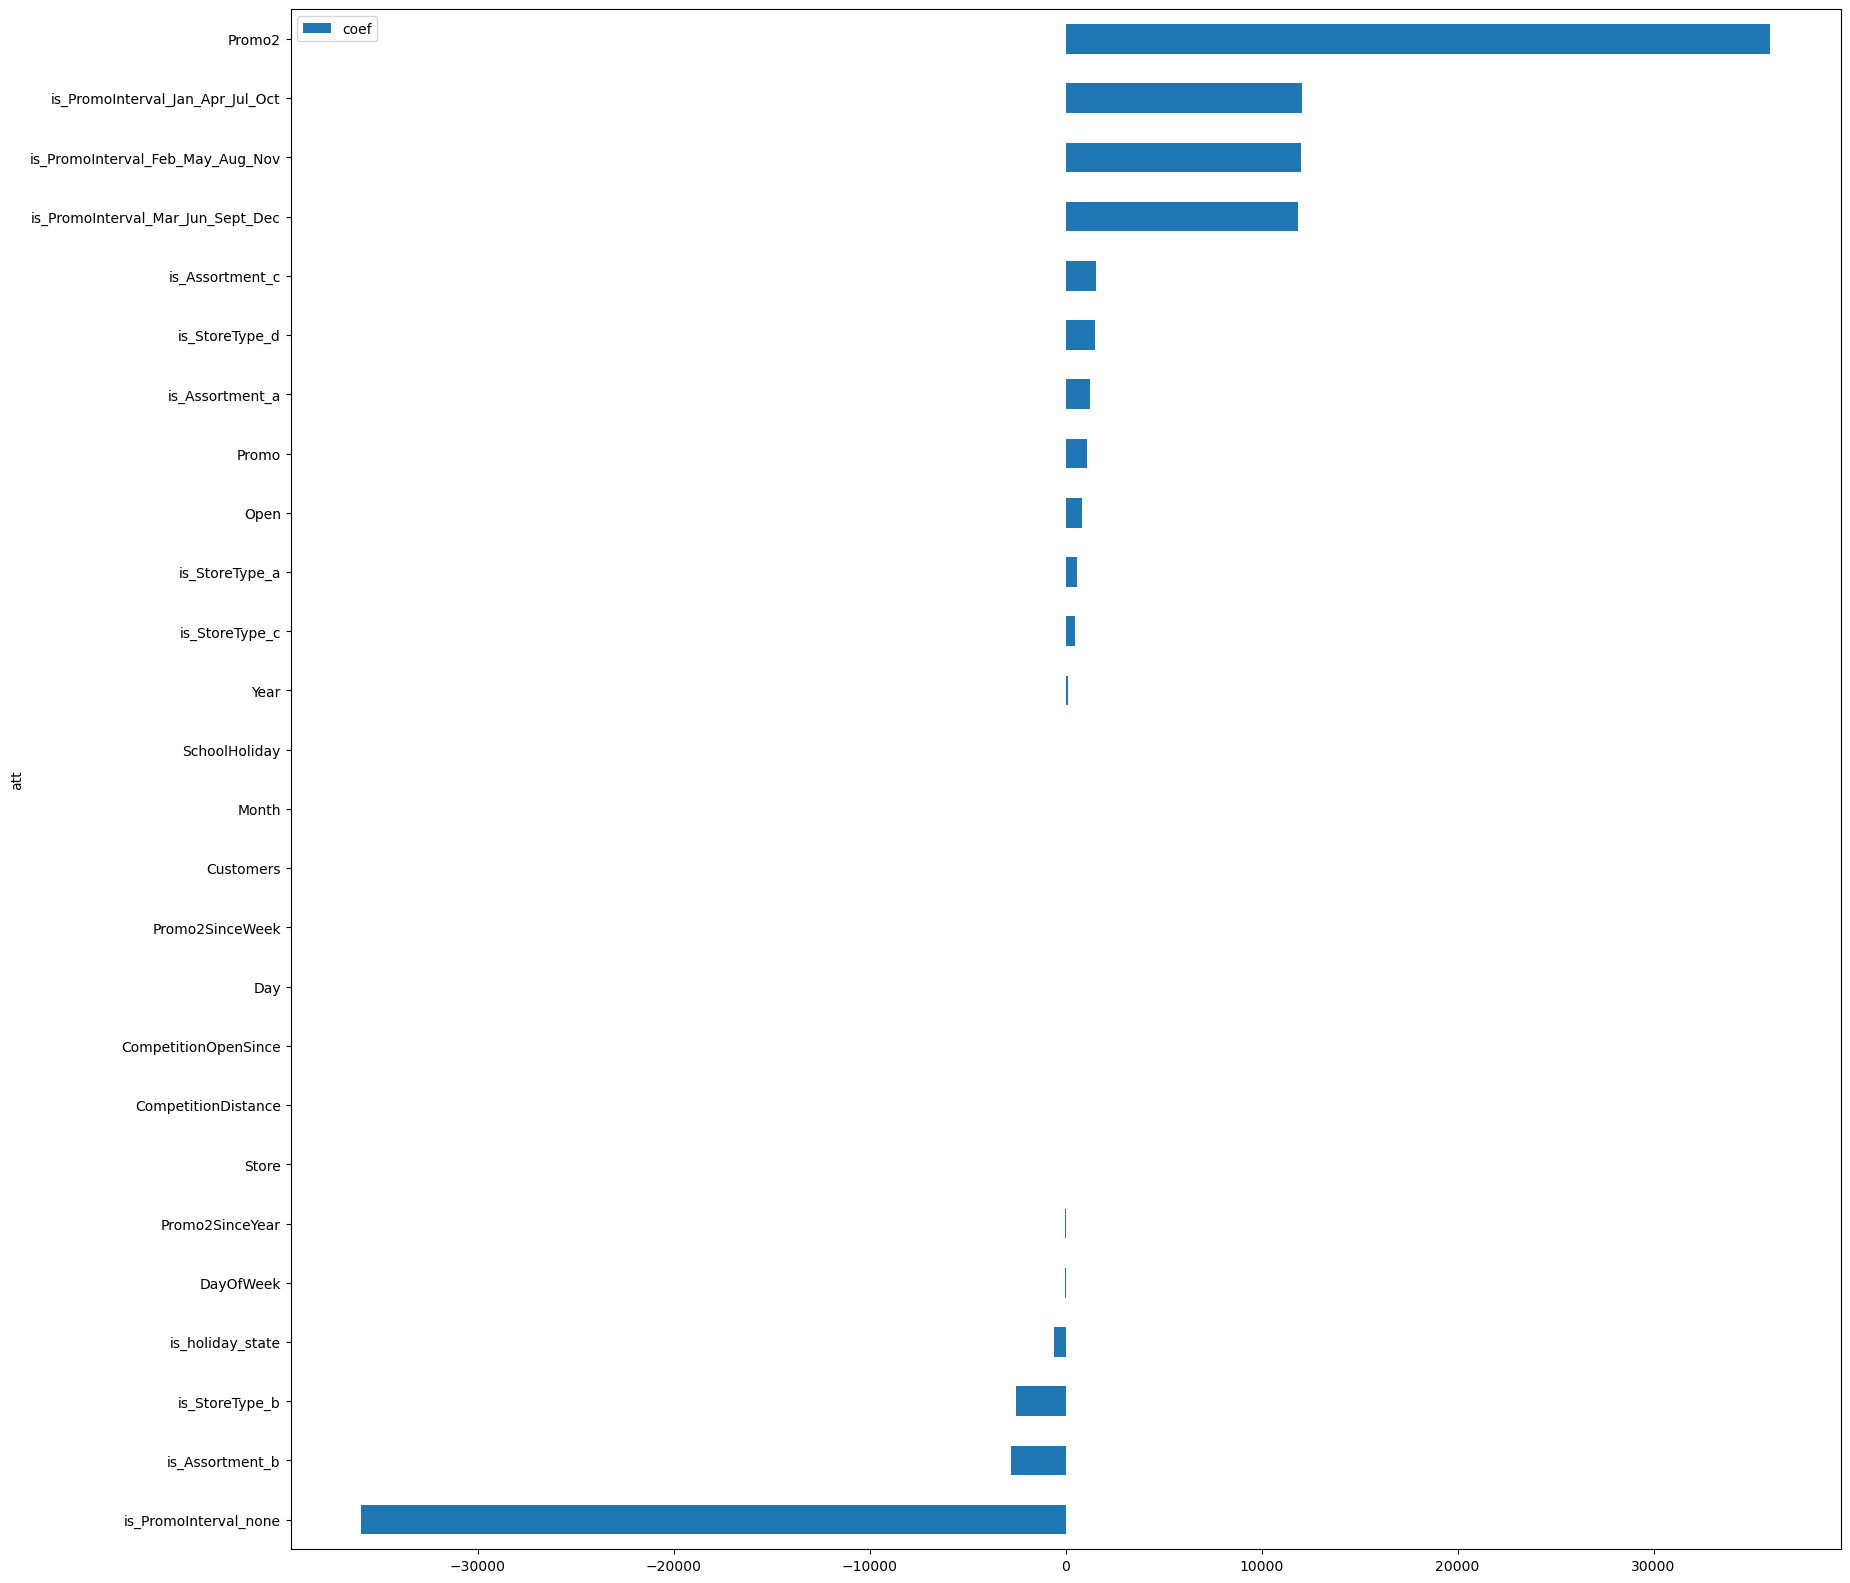

In [113]:
coefs = pd.DataFrame({'att':X_train.columns, 'coef':lin_reg.coef_}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()
coefs.plot.barh(x='att',y='coef',figsize=(20, 20))

## Ridge i Lasso

In [114]:
#Ridge
ridge_model=Ridge(alpha=1)
cv_dict = cross_validate(ridge_model, X_train, y_train, cv = 5, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.3066169261932373, 0.010570010483615857),
 'score_time': (0.020406436920166016, 0.0013731031852327942),
 'test_MAE': (-870.9935857141724, 1.3488552277090917),
 'train_MAE': (-870.9513980987309, 0.43902693589994185),
 'test_RMSE': (-1212.5578409112873, 3.7151274694143344),
 'train_RMSE': (-1212.4830069858751, 0.9317513840323457),
 'test_R2': (0.9007962667762042, 0.0009469900836959613),
 'train_R2': (0.9008133445397186, 0.0002372289360355994)}

In [115]:
#Lasso
lasso_model=Lasso(alpha=1)
cv_dict = cross_validate(lasso_model, X_train, y_train, cv = 5, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (1.9652274131774903, 0.07557214986886197),
 'score_time': (0.02180962562561035, 0.0032033545211374607),
 'test_MAE': (-871.0394794013216, 1.3111608960359664),
 'train_MAE': (-870.999784863336, 0.423985582968848),
 'test_RMSE': (-1213.0898119470426, 3.6963332649115475),
 'train_RMSE': (-1213.0163343379622, 0.9238967310412722),
 'test_R2': (0.9007092284123797, 0.0009441178213208997),
 'train_R2': (0.9007260682141267, 0.00023696022988816648)}

# Drvo odlučivanja


In [116]:
DT = DecisionTreeRegressor(max_depth = 10, min_samples_split = 15)
cv_dict = cross_validate(DT, X_train, y_train, cv = 5, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (2.7088640213012694, 0.08116357511460107),
 'score_time': (0.032375001907348634, 0.0029416240333691116),
 'test_MAE': (-652.6707542341476, 1.7700231957316388),
 'train_MAE': (-645.8555633061213, 0.8283613577298409),
 'test_RMSE': (-985.3057314456206, 2.2935511136202438),
 'train_RMSE': (-972.8482812576583, 1.1834558754117956),
 'test_R2': (0.9344978326081794, 0.00041408880740130446),
 'train_R2': (0.9361454267647442, 0.00016646575285769082)}

###### Dobijamo bolje rezultate nego sa redukovanim skupom atributa, tako da zadržavamo ceo skup.

# Optimizacija

## Optimizacija parametra za Ridge i Lasso

In [117]:
lasso_and_ridge_params = {"alpha": np.linspace(start=0, stop=5, num=6)}

In [118]:
grid = GridSearchCV(Ridge(), lasso_and_ridge_params, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train,y_train)

print('Best param: ', grid.best_params_)

Best param:  {'alpha': 0.0}


In [119]:
grid = GridSearchCV(Lasso(), lasso_and_ridge_params, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train,y_train)

print('Best param: ', grid.best_params_)

Best param:  {'alpha': 0.0}


In [120]:
#Ridge
ridge_model=Ridge(alpha=0)
cv_dict = cross_validate(ridge_model, X_train, y_train, cv = 5, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (0.8267399787902832, 0.0074113339420979725),
 'score_time': (0.024350643157958984, 0.0036984227217644384),
 'test_MAE': (-870.4211562190576, 1.4349419959766243),
 'train_MAE': (-870.3772541317627, 0.4598180899026539),
 'test_RMSE': (-1212.1100750614642, 3.7680387326348055),
 'train_RMSE': (-1212.0316129410653, 0.940567064782644),
 'test_R2': (0.90086951386221, 0.000949716232497324),
 'train_R2': (0.9008871827255195, 0.00023764793314205796)}

In [121]:
#Lasso
lasso_model=Lasso(alpha=0)
cv_dict = cross_validate(lasso_model, X_train, y_train, cv = 5, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (13.98894100189209, 0.10661461432065464),
 'score_time': (0.02076067924499512, 0.001956277965694448),
 'test_MAE': (-871.4870721992532, 1.3240534186414172),
 'train_MAE': (-871.4466519836848, 0.4248214113850311),
 'test_RMSE': (-1212.9982511967532, 3.6995114654608976),
 'train_RMSE': (-1212.9250341441107, 0.9240056225381316),
 'test_R2': (0.9007241928037487, 0.0009465803130592126),
 'train_R2': (0.9007410117672077, 0.00023693472572087256)}

## Optimizacija parametra za Drvo odlučivanja

In [122]:
params = {"max_depth": [5,10,12,15,20],
         "min_samples_split":[60,100,120,150,200]}

In [123]:
grid = GridSearchCV(DecisionTreeRegressor(), params, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(X_train,y_train)

print('Best param: ', grid.best_params_)

Best param:  {'max_depth': 20, 'min_samples_split': 60}


In [124]:
DT = DecisionTreeRegressor(max_depth = 20, min_samples_split = 60)
cv_dict = cross_validate(DT, X_train, y_train, cv = 5, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'}, return_train_score=True)
error_stats(cv_dict)

{'fit_time': (3.8405553340911864, 0.0766605906977886),
 'score_time': (0.04412755966186523, 0.004907482781185147),
 'test_MAE': (-391.65673179221636, 2.197154553391051),
 'train_MAE': (-348.70011964287147, 1.5354684947330777),
 'test_RMSE': (-652.844622135639, 5.235098234561164),
 'train_RMSE': (-569.5693883179954, 2.6371009276674156),
 'test_R2': (0.9712416112516691, 0.0005005005577670236),
 'train_R2': (0.9781121324806732, 0.00020201736801271094)}

######  Nakon optimizacije dobijamo još bolje modele

# Ansambli 

In [125]:
model_stacking = StackingClassifier(classifiers=[DT, lin_reg, lasso_model, ridge_model], meta_classifier = LinearRegression())

In [126]:
# STACKING
scores = cross_validate(model_stacking, X_train, y_train, cv=5, scoring={'MAE':'neg_mean_absolute_error', 'RMSE':rmse, 'R2':'r2'})
error_stats(scores)

{'fit_time': (19.294761753082277, 0.5516026846006956),
 'score_time': (0.10184321403503419, 0.006868221237280197),
 'test_MAE': (-394.82858645142744, 0.7831056031806107),
 'test_RMSE': (-650.3330001359966, 3.3049318746681533),
 'test_R2': (0.9714644327059686, 0.0003071764155368078)}

# Predickije

In [127]:
y_hat_lin_reg=lin_reg.fit(X_train,y_train).predict(X_test)

In [128]:
y_hat_ridge=ridge_model.fit(X_train,y_train).predict(X_test)

In [129]:
y_hat_lasso=lasso_model.fit(X_train,y_train).predict(X_test)

In [130]:
y_hat_dt=DT.fit(X_train,y_train).predict(X_test)

In [131]:
y_hat_stacking=model_stacking.fit(X_train,y_train).predict(X_test)

## Evaluacija modela

### Linearna regresija

In [132]:
mae(y_test, y_hat_lin_reg)

871.4394679493797

In [133]:
r2(y_test, y_hat_lin_reg)

0.9011154879484239

In [134]:
rmse_score(y_test, y_hat_lin_reg)

1210.6594031292118

### Ridge

In [135]:
mae(y_test, y_hat_ridge)

871.4338177305807

In [136]:
r2(y_test, y_hat_ridge)

0.9011154605121491

In [137]:
rmse_score(y_test, y_hat_ridge)

1210.65957108283

## Lasso

In [138]:
mae(y_test, y_hat_lasso)

872.4731039655906

In [139]:
r2(y_test, y_hat_lasso)

0.9009709089266215

In [140]:
rmse_score(y_test, y_hat_lasso)

1211.5441322709755

In [141]:
roc_auc(y_test, y_hat_lasso)

ValueError: multi_class must be in ('ovo', 'ovr')

## Drvo odlučivanja

In [ ]:
mae(y_test, y_hat_dt)

In [ ]:
r2(y_test, y_hat_dt)

In [ ]:
rmse_score(y_test, y_hat_dt)

In [ ]:
plt.scatter(y_test, y_hat_dt)

## Stacking

In [ ]:
mae(y_test, y_hat_stacking)

In [ ]:
r2(y_test, y_hat_stacking)

In [ ]:
rmse_score(y_test, y_hat_stacking)

In [ ]:
plt.scatter(y_test, y_hat_stacking)

###### Model koji najbolje vrši predikcije je Stacking.

# Zaključak i budući pravci

###### Iako je su modeli dali vrlo dobre rezultate, možda bi najbolje bilo pokušati primeniti neki od modela za vremenske serije. Problem predviđanja prodaje se najčešće rešava primenom modela za vremenske serije i neki od mogućih pravaca je korišćenje neuronske mreže.

In [ ]:
df